## 제 5 장 과제  
2018320241 정소희

### Data load, split, reshape 

In [1]:
import tensorflow as tf
fashion_mnist=tf.keras.datasets.fashion_mnist
(x_train,y_train_sparse),(x_test,y_test_sparse)=fashion_mnist.load_data()
shape1=x_train.shape[1]
shape2=x_train.shape[2]
from tensorflow.keras.utils import to_categorical
#cnn 에 쓸 수 있도록 4D tensor 로 reshape 한다.
x_train=x_train.reshape(-1, shape1,shape2,1).astype('float32')
x_test=x_test.reshape(-1, shape1,shape2,1).astype('float32')
y_train=to_categorical(y_train_sparse)
y_test=to_categorical(y_test_sparse)
x_train=x_train/255.0
x_test=x_test/255.0

### Subclassing API 로 CNN model 생성
overfitting을 방지하기 위해 기본적인 CNN 모델에 아래와 같은 요소들을 추가하였다.
* batchnormalization, dropout layer를 적용하였다.
* 모수 초기치를 부여하였다. (ex: kernel_initializer = 'he_normal')
* 활성함수를 변경하였다. relu 대신 elu와 selu를 적용하였다.
* 출력층에 L1 규제화를 적용하였다.

In [2]:
input_shape=(shape1,shape2,1) #흑백 사진 1장
num_labels = 10
batch_size=64
kernel_size=3
pool_size=2
filters=64
dropout=0.3

In [3]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization

class CNNModel(tf.keras.models.Model): 
    def __init__(self, activation='elu',
                 input_shape = (x_train.shape[1],x_train.shape[2],1),
                 num_labels=10,
                 kernel_size=3,
                 pool_size=2,
                 filters=64,
                 dropout=0.3, **kwargs):
        super().__init__(**kwargs)
        
        self.conv1 = Conv2D(filters=filters,kernel_size=kernel_size,activation=activation,input_shape=input_shape,kernel_initializer='he_normal')
        self.batchnorm1 = BatchNormalization(momentum=0.9)
        self.maxpool1 = MaxPooling2D(pool_size)
        self.dropout1 = Dropout(dropout)
        
        self.conv2 = Conv2D(filters=filters,kernel_size=kernel_size,activation=activation,kernel_initializer='he_normal')
        self.batchnorm2 = BatchNormalization(momentum=0.9)
        self.maxpool2 = MaxPooling2D(pool_size)
        self.dropout2 = Dropout(dropout)
        
        self.conv3 = Conv2D(filters=filters,kernel_size=kernel_size,activation=activation,kernel_initializer='he_normal')
        self.batchnorm3 = BatchNormalization(momentum=0.9)
        self.maxpool3 = MaxPooling2D(pool_size)
        self.dropout3 = Dropout(dropout)
        
        self.flat = Flatten()
        self.dense1 = Dense(128,activation='selu',kernel_initializer='lecun_normal')
        self.batchnorm4 = BatchNormalization(momentum=0.9)
        self.dropout4 = Dropout(dropout)
        self.dense2 = Dense(num_labels, activation='softmax', kernel_regularizer='l1')
        
    def call(self,inputs):
        h = self.conv1(inputs)
        h = self.batchnorm1(h)
        h = self.maxpool1(h)
        h = self.dropout1(h)
        
        h = self.conv2(h)
        h = self.batchnorm2(h)
        h = self.maxpool2(h)
        h = self.dropout2(h)
        
        h = self.conv3(h)
        h = self.batchnorm3(h)
        h = self.maxpool3(h)
        h = self.dropout3(h)
        
        h = self.flat(h)
        h = self.dense1(h)
        h = self.batchnorm4(h)
        h = self.dropout4(h)
        h = self.dense2(h)
        return h
    
model=CNNModel()

In [7]:
model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  640       
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0 

### Compile and Fit
* 다항 분류 문제이므로 loss함수로 categorical crossentropy를 적용하였다.
* epoch를 40으로 두고 earlystopping을 patience=3으로 적용하였다.

In [4]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

callback_list = [EarlyStopping(monitor='accuracy',patience=3),
                 ModelCheckpoint(filepath='model_boston_1.h5',monitor='val_loss',save_best_only='True')]

model.compile(loss='categorical_crossentropy',optimizer='nadam', metrics=['accuracy'])
results = model.fit(x_train,y_train, batch_size=32, epochs=40,validation_split=0.1, callbacks=callback_list)

Epoch 1/40
1688/1688 [==============================] - 180s 102ms/step - loss: 1.7145 - accuracy: 0.6520 - val_loss: 0.7115 - val_accuracy: 0.8250
Epoch 2/40
1688/1688 [==============================] - 157s 93ms/step - loss: 0.7877 - accuracy: 0.8043 - val_loss: 0.5779 - val_accuracy: 0.8535
Epoch 3/40
1688/1688 [==============================] - 167s 99ms/step - loss: 0.6838 - accuracy: 0.8289 - val_loss: 0.5254 - val_accuracy: 0.8652
Epoch 4/40
1688/1688 [==============================] - 164s 97ms/step - loss: 0.6286 - accuracy: 0.8419 - val_loss: 0.4954 - val_accuracy: 0.8703
Epoch 5/40
1688/1688 [==============================] - 166s 98ms/step - loss: 0.5874 - accuracy: 0.8523 - val_loss: 0.4773 - val_accuracy: 0.8797
Epoch 6/40
1688/1688 [==============================] - 166s 98ms/step - loss: 0.5708 - accuracy: 0.8561 - val_loss: 0.4619 - val_accuracy: 0.8812
Epoch 7/40
1688/1688 [==============================] - 166s 98ms/step - loss: 0.5449 - accuracy: 0.8594 - val_loss: 

KeyboardInterrupt: 

### Result
* 학습 결과 train accuracy와 validation accuracy가 중간에 줄어들지 않고 계속 증가했으며, train과 validation 사이에 accuracy 차이가 거의 없고 비슷하게 증가하는 것으로 보아 과대적합이 일어나지 않았음을 알 수 있다.
* test data로 정밀도를 측정해본 결과 0.8977로 높게 나타났다.
* plot을 통해서도 과대적합이 일어나지 않은 것을 관찰할 수 있다.

In [6]:
result=model.evaluate(x_test,y_test, batch_size=128)
print(result)

79/79 [==============================] - 4s 51ms/step - loss: 0.3778 - accuracy: 0.8977
[0.3778020441532135, 0.8977000117301941]


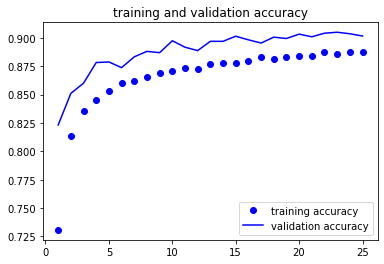

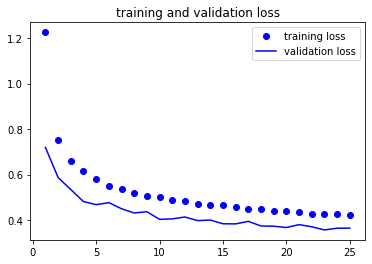

In [8]:
import matplotlib.pyplot as plt
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='training accuracy')
plt.plot(epochs, val_acc,'b',label='validation accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs, val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()